# Import libraries

In [1]:
!pip install contractions bertopic vaderSentiment sentence-transformers networkx ipysigma
!pip install nltk==3.9
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py ipysigma

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [-

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import os
import json
import time
import networkx as nx
import contractions
import nltk

# download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from ipysigma import Sigma
from itertools import combinations
from collections import Counter

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS

from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\samid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load data

In [3]:
# collect all the file names in the directory
# directory_path = '/kaggle/input/donald-trump-2024-transcripts/data/text'
directory_path = 'text'

file_names = []

for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory_path, filename)
        file_names.append(filename)

In [4]:
# directory containing .txt files
# directory = "/kaggle/input/donald-trump-2024-transcripts/data/text"  
directory = 'text'


# function to extract information
def extract_info(filename):
    filename1 = filename
    
    # remove some words from the filename
    for word in ['speak', 'speaks', 'holds', 'deliver', 'former', 'takes', 'delivers']:
        filename = filename.replace(word, "")
    

    # extract date
    date_match = re.search(r"(\d{8})", filename)
    date = date_match.group(1) if date_match else "Unknown"
    date = pd.to_datetime(date, format="%Y%m%d", errors="coerce").strftime("%Y-%m-%d")
    # extract location
    location_match = re.search(r"in-([a-z\-]+)(?:\.|_|\-)", filename)
    location_match1 = re.search(r"at-([a-z\-]+)(?:\.|_|\-)", filename)
    if location_match:
        location = location_match.group(1).replace("-", " ").title() 
    elif location_match1: 
        location = location_match1.group(1).replace("-", " ").title()
    else:
        location = "Unknown"
    
    location = location.replace('Transcript', '') if 'Transcript' in location else location
    location = location.replace('Rally', '') if 'Rally' in location else location
    location = location.strip()

    # Extract speaker
    speaker = "Donald Trump" if "trump" in filename.lower() or "donald-trump" in filename.lower() else "Unknown"

    if "vance-and-trump" in filename.lower():
        speaker = "Donald Trump and J.D. Vance"
    
    # extract title
    title_match = re.search(r"(rally|town-hall|speech|address|interview)", filename.lower())
    title = title_match.group(1).replace("-", " ").title() if title_match else "Unknown"
    
    # extract speech content
    file_path = os.path.join(directory, filename1)
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            speech = file.read()
    except FileNotFoundError:
        speech = "File not found"
    except Exception as e:
        speech = f"Error reading file: {e}"
    
    return {
        "date": date,
        "location": location,
        "deliverer": speaker,
        "title": title,
        "speech": speech
    }

# process all filenames
speech_data = [extract_info(name) for name in file_names]

# create a DataFrame for better visualization
speech_df = pd.DataFrame(speech_data).sort_values(by="date").reset_index(drop=True)

# save the DataFrame to a CSV
speech_df.to_csv("speech_data.csv", index=False)


In [5]:
speech_df = pd.read_csv("speech_data.csv")
speech_df['date'] = pd.to_datetime(speech_df['date'])

speech_df

date                                        location     deliverer  \
0  2022-11-07                                    Pa For Dr Oz  Donald Trump   
1  2022-11-16                                         Unknown  Donald Trump   
2  2023-02-01  New York Attorney Generals Fraud Investigation  Donald Trump   
3  2023-03-06                                            Cpac  Donald Trump   
4  2023-03-14                                  Davenport Iowa  Donald Trump   
..        ...                                             ...           ...   
94 2024-10-24                       Greensboro North Carolina  Donald Trump   
95 2024-10-28                                   Novi Michigan  Donald Trump   
96 2024-10-28                      State College Pennsylvania  Donald Trump   
97 2024-10-28                                         Unknown  Donald Trump   
98 2024-10-28                           Madison Square Garden  Donald Trump   

        title                                             speech  
0       Rally  \nYou’re going to elect Dr. Mehmet Oz to the U...  
1     Unknown  \nWell, thank you very much, and on behalf of ...  
2     Unknown  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...  
3     Unknown  \nWell, thank you very much and I’m thrilled t...  
4      Speech  \nOh, thank you very much. Thank you very much...  
..        ...                                                ...  
94      Rally  \nThank you.(26:51)Remember when I said no tax...  
95      Rally  \nWhen I’m re-elected, I will totally oblitera...  
96      Rally  \nWow.\n\n\nWell, thank you very much. This is...  
97  Interview  \nLet’s go.\n\n\nSure.\n\n\nThat’s right.\n\n\...  
98      Rally  \nThis is the final battle. With you at my sid...  

[99 rows x 5 columns]

# Data Preprocessing

The first round of the 2024 U.S. presidential election primaries began on January 15, 2024, with the Iowa caucuses, followed by the New Hampshire primary. So I use data starting from 2024-01-01.

In [6]:
# Load the dataset
df = speech_df[speech_df.date >= '2024-01-01'].copy()
df = df.sort_values(by=['date']).reset_index(drop=True)

# initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# clean a single speech
def clean_speech(speech):
    
    # apply contractions
    speech = contractions.fix(speech)
    
    # remove speaker labels, timestamps, and non-alphanumeric characters
    speech = re.sub(r"\d2:\d2\d{2}:\d{2}", "", speech)  # remove timestamps
    speech = re.sub(r"[^\w\s]", " ", speech)         # remove punctuation
    speech = re.sub(r"\s+", " ", speech)             # remove extra spaces
    
    # convert to lowercase
    speech = speech.lower()
    
    # tokenize into sentences
    sentences = sent_tokenize(speech)
    
    # tokenize words, remove stopwords, and lemmatize
    cleaned_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        cleaned_sentences.append(" ".join(tokens))
    
    return " ".join(cleaned_sentences)

# apply the cleaning 
df['cleaned_speech'] = df['speech'].apply(clean_speech)

df

date                    location     deliverer      title  \
0  2024-01-08           Sioux Center Iowa  Donald Trump      Rally   
1  2024-01-22     Rochester New Hampshire  Donald Trump    Unknown   
2  2024-01-29                   Las Vegas  Donald Trump      Rally   
3  2024-02-01                     Unknown  Donald Trump    Unknown   
4  2024-02-12              South Carolina  Donald Trump     Speech   
..        ...                         ...           ...        ...   
68 2024-10-24   Greensboro North Carolina  Donald Trump      Rally   
69 2024-10-28               Novi Michigan  Donald Trump      Rally   
70 2024-10-28  State College Pennsylvania  Donald Trump      Rally   
71 2024-10-28                     Unknown  Donald Trump  Interview   
72 2024-10-28       Madison Square Garden  Donald Trump      Rally   

                                               speech  \
0   \nThank you very much. We’re going to take our...   
1   \nThank you. Thank you. Wow, what a crowd. You...   
2   \nThank you very much. Thank you. Thank you.\n...   
3   \nWell, thank you very much. We had a very str...   
4   \nWell, thank you very much, South Carolina. W...   
..                                                ...   
68  \nThank you.(26:51)Remember when I said no tax...   
69  \nWhen I’m re-elected, I will totally oblitera...   
70  \nWow.\n\n\nWell, thank you very much. This is...   
71  \nLet’s go.\n\n\nSure.\n\n\nThat’s right.\n\n\...   
72  \nThis is the final battle. With you at my sid...   

                                       cleaned_speech  
0   thank much going take country back going take ...  
1   thank thank wow crowd got lot people standing ...  
2   thank much thank thank thank much thank know o...  
3   well thank much strong meeting teamster year e...  
4   well thank much south carolina great relations...  
..                                                ...  
68  thank 26 51 remember said tax tip like month l...  
69  elected totally obliterate deep state long pri...  
70  wow well thank much quite gathering getting en...  
71  let u go sure right yeah last week one last sh...  
72  final battle side demolish deep state expel wa...  

[73 rows x 6 columns]

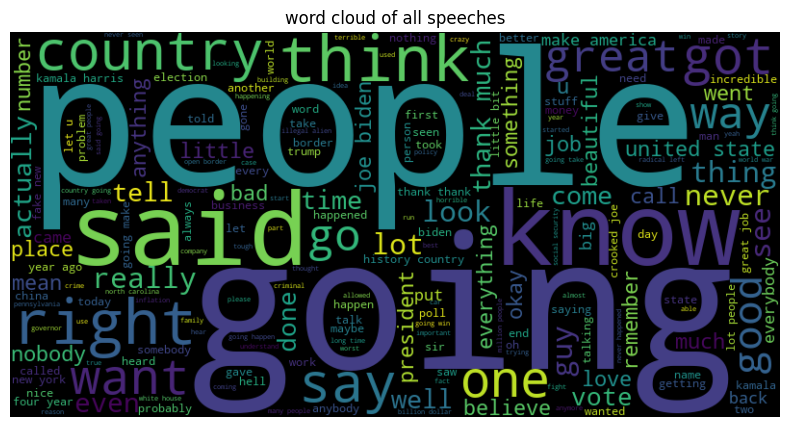

In [7]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800, 
						height=400,
						stopwords=set(STOPWORDS), 
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


cloud_text = df['cleaned_speech'].tolist()
generate_wordcloud(cloud_text,'word cloud of all speeches')

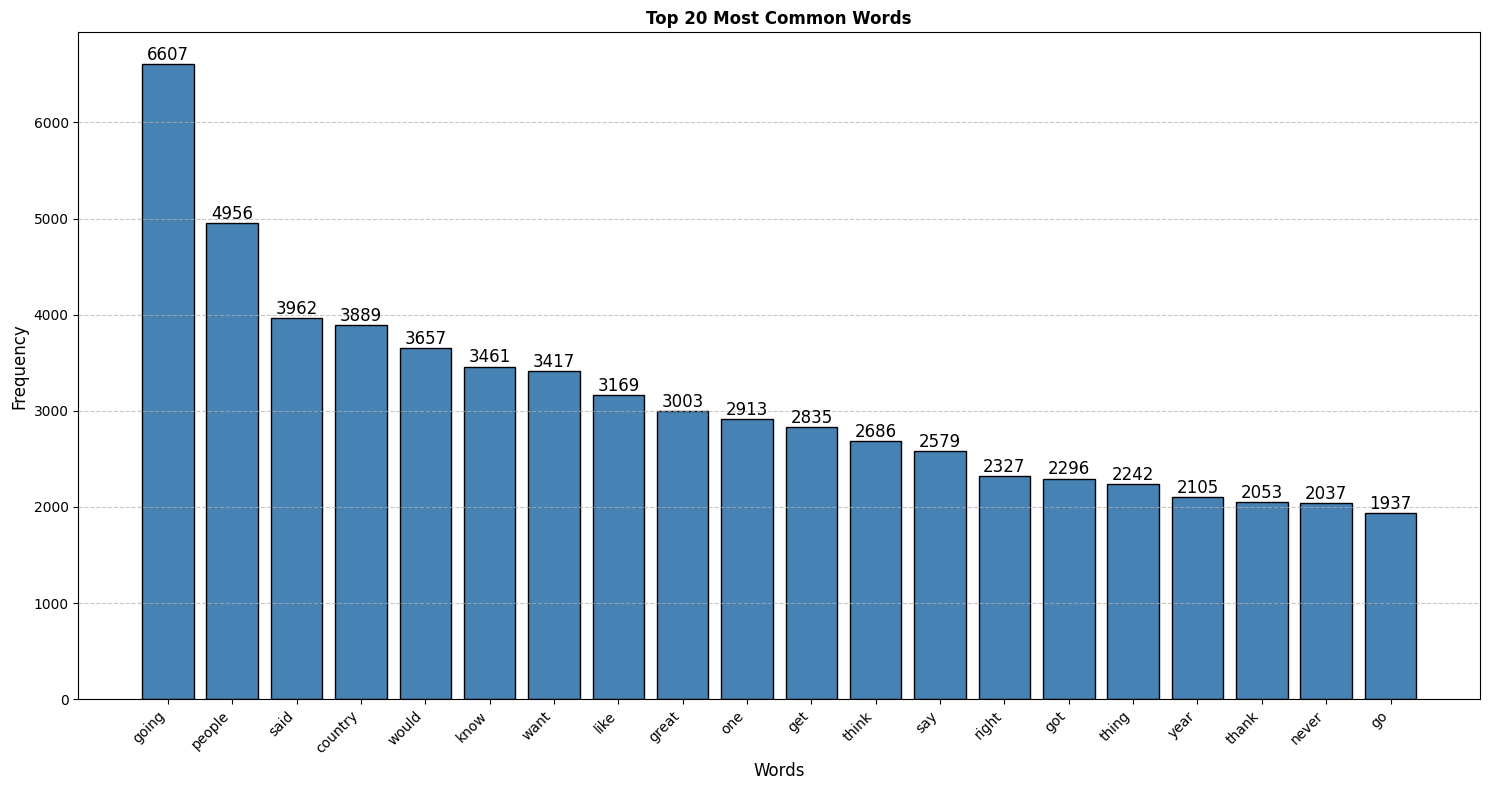

In [8]:
all_words = ' '.join(df['cleaned_speech']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

plt.figure(figsize=(15, 8))
bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

plt.title('Top 20 Most Common Words', fontsize=12, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [9]:
# Tokenization
df['tokens'] = df['cleaned_speech'].apply(word_tokenize)

# Define stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df['tokens_no_stopwords'] = df['tokens'].apply(remove_stopwords)

In [10]:

# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['lemmatized_tokens'] = df['tokens_no_stopwords'].apply(lemmatize_tokens)

# combine tokens back to string for vectorization
df['processed_speech'] = df['lemmatized_tokens'].apply(lambda x: " ".join(x))

df.head(3)

date                 location     deliverer    title  \
0 2024-01-08        Sioux Center Iowa  Donald Trump    Rally   
1 2024-01-22  Rochester New Hampshire  Donald Trump  Unknown   
2 2024-01-29                Las Vegas  Donald Trump    Rally   

                                              speech  \
0  \nThank you very much. We’re going to take our...   
1  \nThank you. Thank you. Wow, what a crowd. You...   
2  \nThank you very much. Thank you. Thank you.\n...   

                                      cleaned_speech  \
0  thank much going take country back going take ...   
1  thank thank wow crowd got lot people standing ...   
2  thank much thank thank thank much thank know o...   

                                              tokens  \
0  [thank, much, going, take, country, back, goin...   
1  [thank, thank, wow, crowd, got, lot, people, s...   
2  [thank, much, thank, thank, thank, much, thank...   

                                 tokens_no_stopwords  \
0  [thank, much, going, take, country, back, goin...   
1  [thank, thank, wow, crowd, got, lot, people, s...   
2  [thank, much, thank, thank, thank, much, thank...   

                                   lemmatized_tokens  \
0  [thank, much, going, take, country, back, goin...   
1  [thank, thank, wow, crowd, got, lot, people, s...   
2  [thank, much, thank, thank, thank, much, thank...   

                                    processed_speech  
0  thank much going take country back going take ...  
1  thank thank wow crowd got lot people standing ...  
2  thank much thank thank thank much thank know o...

# Sentiment Analysis

In [11]:
# sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    if sentiment_score['compound'] >= 0.5:
     return 'positive'
    elif sentiment_score['compound'] < 0:
     return 'negative'
    else:
     return 'neutral'

df['sentiment'] = df['cleaned_speech'].apply(get_sentiment)

In [12]:
px.bar(df, x='date', color='sentiment', title='Sentiment Distribution of Speeches')

In [13]:
# count the number of speeches per location and sentiment
location_sentiment_count = df.groupby(['location', 'date', 'sentiment', 'deliverer', 'title']).size().reset_index(name='count')

# bubble chart
fig = px.scatter(location_sentiment_count, 
                 x='date', 
                 y='location', 
                 size='count', 
                 color='sentiment', 
                 hover_name='deliverer', 
                 hover_data={'title': True, 'count': True},
                 title='Bubble Chart of Speeches by Location and Sentiment')

fig.update_layout(showlegend=True, legend_title_text='Sentiment', width=1000, height=800)

fig.show()

# LDA

In [14]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_speech'])

# Latent Dirichlet Allocation (LDA) for topic modeling
numberOftopics = 15
lda = LatentDirichletAllocation(n_components = numberOftopics, random_state=42)
lda_matrix = lda.fit(tfidf_matrix)

# print the top words for each topic
n_top_words = 20
words = tfidf_vectorizer.get_feature_names_out()
topic_keywords = {}

for topic_idx, topic in enumerate(lda.components_):
    topic_keywords[f"Topic {topic_idx}"] = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {' '.join(topic_keywords[f'Topic {topic_idx}'])}")
    print()
    

Topic 0: brian rigged jim legal furniture catholic remain laken test bruce fani convicted value iraq sending devastated springfield machine door franklin

Topic 1: libertarian nominate sentenced regard skyrocket required neocon crony equity freer stake inclusion grip beloved guidance hateful 77 treaty expensing impartial

Topic 2: robin vow russo survivor kaplan bond understanding escaped humanity intend agony mourn balart heading impacted garcia ileana perez toxic directly

Topic 3: eviscerated gambling journalist officially statute 114 ronnie material lion cardinal 635 chevrolets cooking convicted abuse test sarah zoom libertarian heal

Topic 4: testify disclosure appealing fixer discussion appeal column 114 productive employed pled manufacture marked negotiating courthouse falsification maker cleaned material weekend

Topic 5: cardinal beech salt remembers vogue healthier distinguished install ambition insulted attend invitation suspect exchange blessed carve vulnerable brings mate 

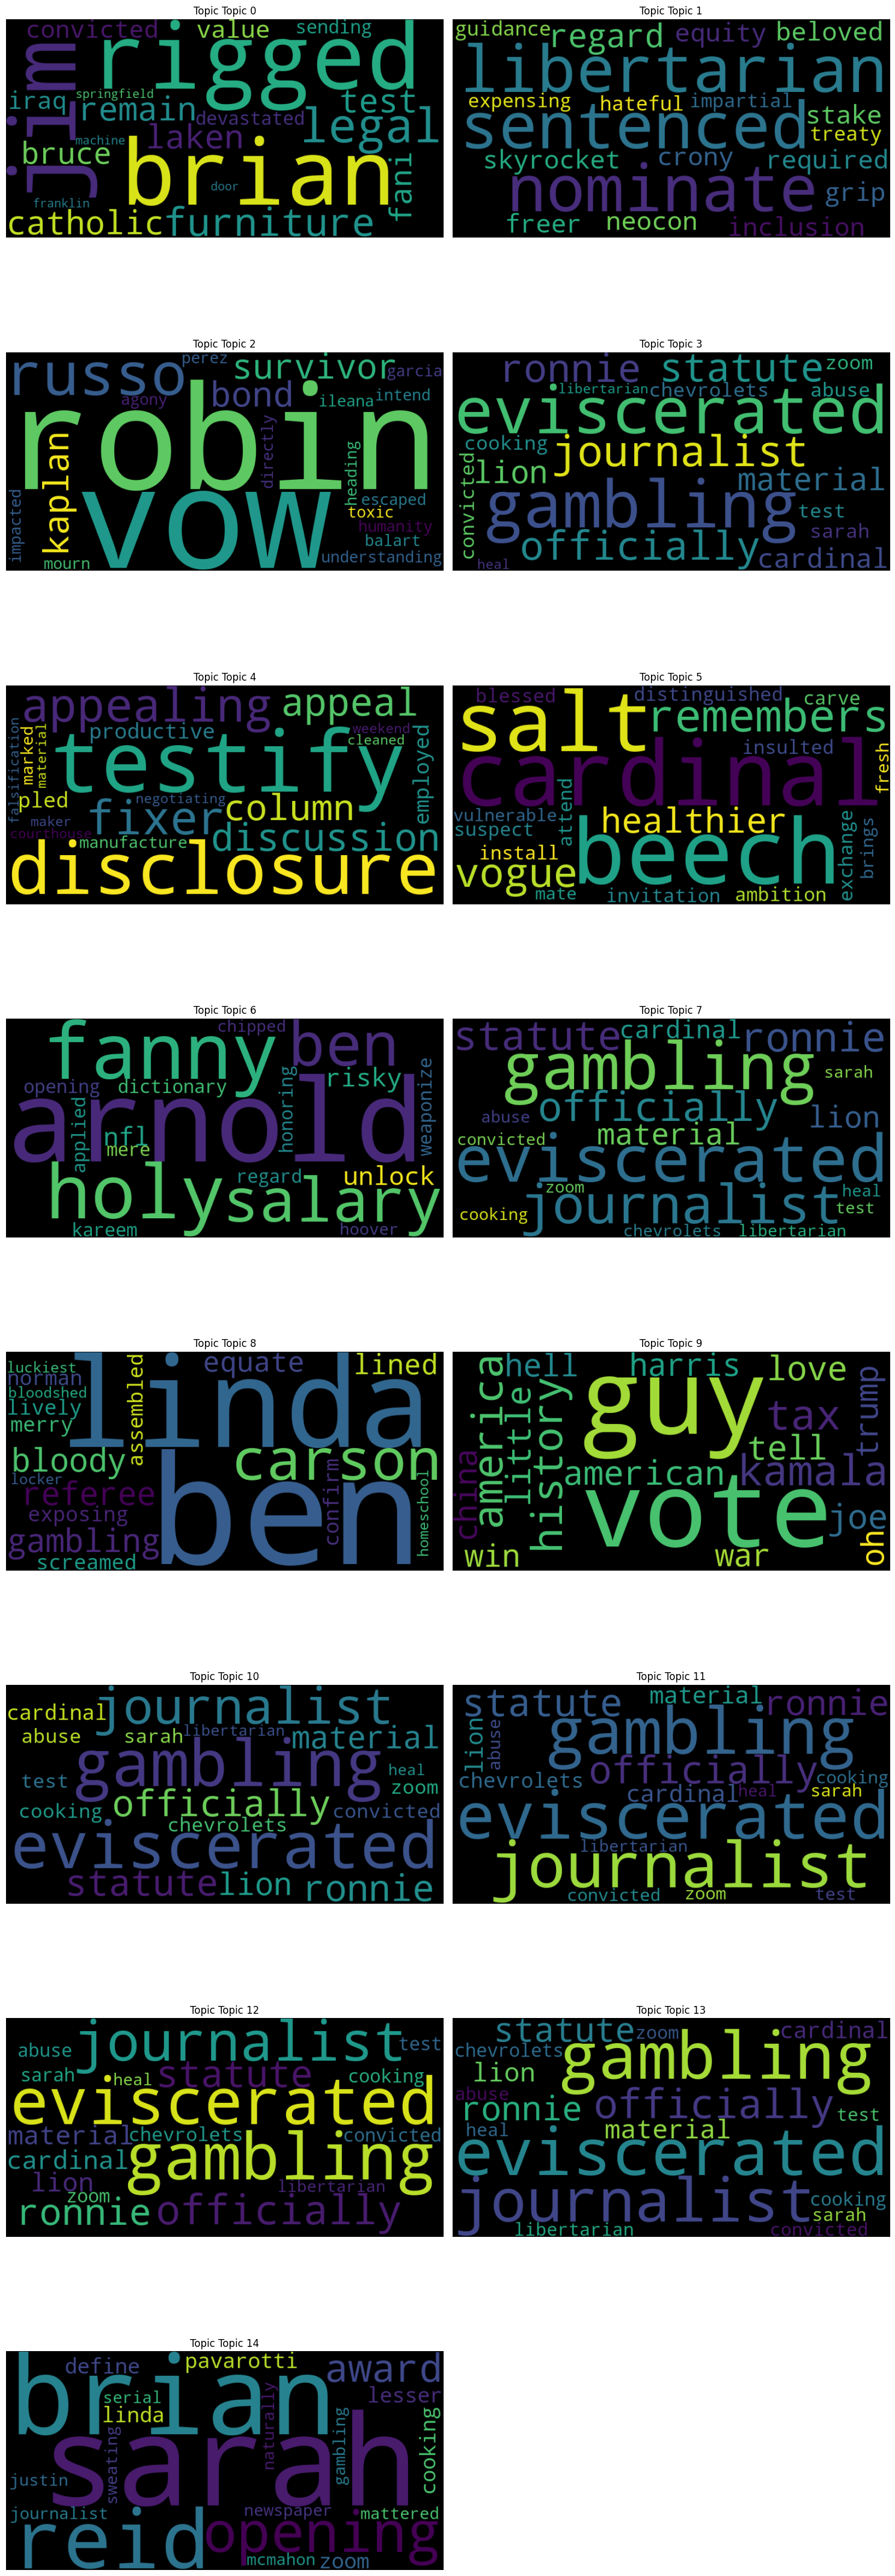

In [15]:
def plot_word_clouds_subplots(topic_keywords):
    num_topics = len(topic_keywords)
    fig, axes = plt.subplots(nrows=(num_topics // 2) + (num_topics % 2), ncols=2, figsize=(15, num_topics * 3))
    axes = axes.flatten()

    for i, (topic, keywords) in enumerate(topic_keywords.items()):
        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(" ".join(keywords))
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f"Topic {topic}")

    # remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_word_clouds_subplots(topic_keywords)

In [16]:
# Display top words in each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:", ", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda, tfidf_feature_names, num_top_words=10)

Topic 0: brian, rigged, jim, legal, furniture, catholic, remain, laken, test, bruce
Topic 1: libertarian, nominate, sentenced, regard, skyrocket, required, neocon, crony, equity, freer
Topic 2: robin, vow, russo, survivor, kaplan, bond, understanding, escaped, humanity, intend
Topic 3: eviscerated, gambling, journalist, officially, statute, 114, ronnie, material, lion, cardinal
Topic 4: testify, disclosure, appealing, fixer, discussion, appeal, column, 114, productive, employed
Topic 5: cardinal, beech, salt, remembers, vogue, healthier, distinguished, install, ambition, insulted
Topic 6: arnold, fanny, holy, 125, salary, ben, risky, nfl, unlock, dictionary
Topic 7: eviscerated, gambling, journalist, officially, statute, 114, ronnie, material, lion, cardinal
Topic 8: ben, linda, carson, gambling, referee, bloody, equate, lined, exposing, lively
Topic 9: 01, guy, vote, kamala, america, tax, history, american, love, joe
Topic 10: eviscerated, gambling, journalist, officially, statute, 11

In [17]:

# assign the topics to the speeches
topic_matrix = lda.transform(tfidf_matrix)
df['topic'] = topic_matrix.argmax(axis=1)

# map topics to keywords for easier interpretation
df['topic_keywords'] = df['topic'].apply(lambda x: ", ".join(topic_keywords[f"Topic {x}"]))

df[['processed_speech', 'topic', 'topic_keywords']]

processed_speech  topic  \
0   thank much going take country back going take ...      9   
1   thank thank wow crowd got lot people standing ...      9   
2   thank much thank thank thank much thank know o...      9   
3   well thank much strong meeting teamster year e...      9   
4   well thank much south carolina great relations...      9   
..                                                ...    ...   
68  thank 26 51 remember said tax tip like month l...      9   
69  elected totally obliterate deep state long pri...      9   
70  wow well thank much quite gathering getting en...      9   
71  let u go sure right yeah last week one last sh...      9   
72  final battle side demolish deep state expel wa...      9   

                                       topic_keywords  
0   01, guy, vote, kamala, america, tax, history, ...  
1   01, guy, vote, kamala, america, tax, history, ...  
2   01, guy, vote, kamala, america, tax, history, ...  
3   01, guy, vote, kamala, america, tax, history, ...  
4   01, guy, vote, kamala, america, tax, history, ...  
..                                                ...  
68  01, guy, vote, kamala, america, tax, history, ...  
69  01, guy, vote, kamala, america, tax, history, ...  
70  01, guy, vote, kamala, america, tax, history, ...  
71  01, guy, vote, kamala, america, tax, history, ...  
72  01, guy, vote, kamala, america, tax, history, ...  

[73 rows x 3 columns]

# Predefined topic modeling


In [18]:

# campaign topics
campaign_topics = ["Gun Laws", "Climate", "Crime", "Healthcare", "Tax", "Ukraine", "Abortion", "Immigration", "Economy"]

# speech covers any campaign topics
def check_campaign_topics(speech, topics):
    covered_topics = [topic for topic in topics if topic.lower() in speech.lower()]
    return covered_topics

# check if speech covers any campaign topics
df['covered_campaign_topics'] = df['cleaned_speech'].apply(lambda x: check_campaign_topics(x, campaign_topics))

df[['date', 'location', 'deliverer', 'title', 'covered_campaign_topics']]

date                    location     deliverer      title  \
0  2024-01-08           Sioux Center Iowa  Donald Trump      Rally   
1  2024-01-22     Rochester New Hampshire  Donald Trump    Unknown   
2  2024-01-29                   Las Vegas  Donald Trump      Rally   
3  2024-02-01                     Unknown  Donald Trump    Unknown   
4  2024-02-12              South Carolina  Donald Trump     Speech   
..        ...                         ...           ...        ...   
68 2024-10-24   Greensboro North Carolina  Donald Trump      Rally   
69 2024-10-28               Novi Michigan  Donald Trump      Rally   
70 2024-10-28  State College Pennsylvania  Donald Trump      Rally   
71 2024-10-28                     Unknown  Donald Trump  Interview   
72 2024-10-28       Madison Square Garden  Donald Trump      Rally   

                              covered_campaign_topics  
0   [Crime, Healthcare, Tax, Ukraine, Immigration,...  
1          [Crime, Healthcare, Tax, Ukraine, Economy]  
2         [Crime, Tax, Ukraine, Immigration, Economy]  
3                       [Crime, Ukraine, Immigration]  
4                      [Crime, Tax, Ukraine, Economy]  
..                                                ...  
68        [Crime, Tax, Ukraine, Immigration, Economy]  
69        [Crime, Tax, Ukraine, Immigration, Economy]  
70        [Crime, Tax, Ukraine, Immigration, Economy]  
71         [Crime, Healthcare, Tax, Ukraine, Economy]  
72        [Crime, Tax, Ukraine, Immigration, Economy]  

[73 rows x 5 columns]

In [19]:
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#33FFF5', '#FF8C33', '#8C33FF', '#33FF8C', '#FF3333']

# chart based on campaign topics
campaign_topic_count = df.explode('covered_campaign_topics').groupby(['date', 'location', 'covered_campaign_topics']).size().reset_index(name='count')
campaign_topic_count = campaign_topic_count.merge(df[['date', 'location', 'covered_campaign_topics']], on = ['date', 'location'], how = 'left', suffixes=('_exploded', '_full'))
campaign_topic_count['topics'] = campaign_topic_count['covered_campaign_topics_full'].apply(lambda x: ', '.join(set(x)))

fig = px.scatter(campaign_topic_count,
                 x='date',
                 y='location',
                 size='count',
                 color='covered_campaign_topics_exploded',
                 hover_data={'topics': True, 'count': True},
                 title='Bubble Chart of Speeches by Campaign Topic and Location',
                 color_discrete_sequence=colors)

fig.update_layout(showlegend=True, width=1000, height=800)

fig.show()


# Bert topic modeling

In [20]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# load sentence embedding model
# embedding_model = SentenceTransformer('all-MiniLM-L12-v1')
embedding_model = SentenceTransformer('multi-qa-MiniLM-L6-dot-v1')

# generate embeddings
embeddings = embedding_model.encode(df['processed_speech'].tolist(), show_progress_bar=True)

# initialize BERTopic with reduced min_topic_size and n_gram_range
bert_model = BERTopic(
    verbose = True,
    embedding_model = None,  
    min_topic_size = 5,
    n_gram_range = (1, 15),
    language = "english",
    calculate_probabilities = True
)

# fit the model and transform the data
bert_topics, _ = bert_model.fit_transform(df['processed_speech'], embeddings)

# check topic information
topic_info = bert_model.get_topic_info()
topic_info

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.49k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2024-12-30 11:16:45,760 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-30 11:17:11,728 - BERTopic - Dimensionality - Completed ✓
2024-12-30 11:17:11,729 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-30 11:17:11,763 - BERTopic - Cluster - Completed ✓
2024-12-30 11:17:11,769 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-30 11:18:05,721 - BERTopic - Representation - Completed ✓


Topic  Count                         Name  \
0     -1     32   -1_going_people_would_said   
1      0     23  0_going_people_said_country   
2      1     18  1_going_people_country_said   

                                      Representation  \
0  [going, people, would, said, country, know, wa...   
1  [going, people, said, country, would, like, kn...   
2  [going, people, country, said, want, know, wou...   

                                 Representative_Docs  
0  [thank much everybody thank thank much great h...  
1  [well thank much south carolina great relation...  
2  [first came office cut tax president created s...

In [21]:
# bert_model.visualize_topics()

In [22]:
bert_model.get_topic_info().head(20)

Topic  Count                         Name  \
0     -1     32   -1_going_people_would_said   
1      0     23  0_going_people_said_country   
2      1     18  1_going_people_country_said   

                                      Representation  \
0  [going, people, would, said, country, know, wa...   
1  [going, people, said, country, would, like, kn...   
2  [going, people, country, said, want, know, wou...   

                                 Representative_Docs  
0  [thank much everybody thank thank much great h...  
1  [well thank much south carolina great relation...  
2  [first came office cut tax president created s...

In [23]:
bert_model.visualize_barchart()

In [24]:
bert_model.visualize_term_rank()

# Kmeans clustering

In [25]:
# load the pre-trained BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# generate BERT embeddings for each document
embeddings = model.encode(df['speech'].tolist(), show_progress_bar=True)

# apply KMeans clustering to identify topics
num_topics = 10
kmeans = KMeans(n_clusters=num_topics, max_iter = 500, random_state=42)
kmeans.fit(embeddings)
df['topic'] = kmeans.labels_

# Inspect the DataFrame
df[['cleaned_speech', 'topic']].head()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

cleaned_speech  topic
0  thank much going take country back going take ...      4
1  thank thank wow crowd got lot people standing ...      8
2  thank much thank thank thank much thank know o...      8
3  well thank much strong meeting teamster year e...      1
4  well thank much south carolina great relations...      8

In [26]:

def get_top_words_per_topic(df, num_words=10):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['cleaned_speech'])
    terms = vectorizer.get_feature_names_out()
    topic_keywords = {}

    for topic in range(num_topics):
        topic_docs = df[df['topic'] == topic]['cleaned_speech']
        topic_vector = vectorizer.transform(topic_docs)
        word_counts = topic_vector.sum(axis=0).A1
        top_word_indices = word_counts.argsort()[-num_words:][::-1]
        top_words = [terms[i] for i in top_word_indices]
        topic_keywords[f"Topic {topic}"] = top_words

    return topic_keywords

topic_keywords = get_top_words_per_topic(df)

# map topics to keywords for easier interpretation
df['topic_keywords'] = df['topic'].apply(lambda x: ", ".join(topic_keywords[f"Topic {x}"]))

# inspect the DataFrame
df[['cleaned_speech', 'topic', 'topic_keywords']].head()

cleaned_speech  topic  \
0  thank much going take country back going take ...      4   
1  thank thank wow crowd got lot people standing ...      8   
2  thank much thank thank thank much thank know o...      8   
3  well thank much strong meeting teamster year e...      1   
4  well thank much south carolina great relations...      8   

                                      topic_keywords  
0  going, people, said, country, like, want, know...  
1  going, people, country, said, know, want, like...  
2  going, people, country, said, know, want, like...  
3  going, people, country, said, know, want, grea...  
4  going, people, country, said, know, want, like...

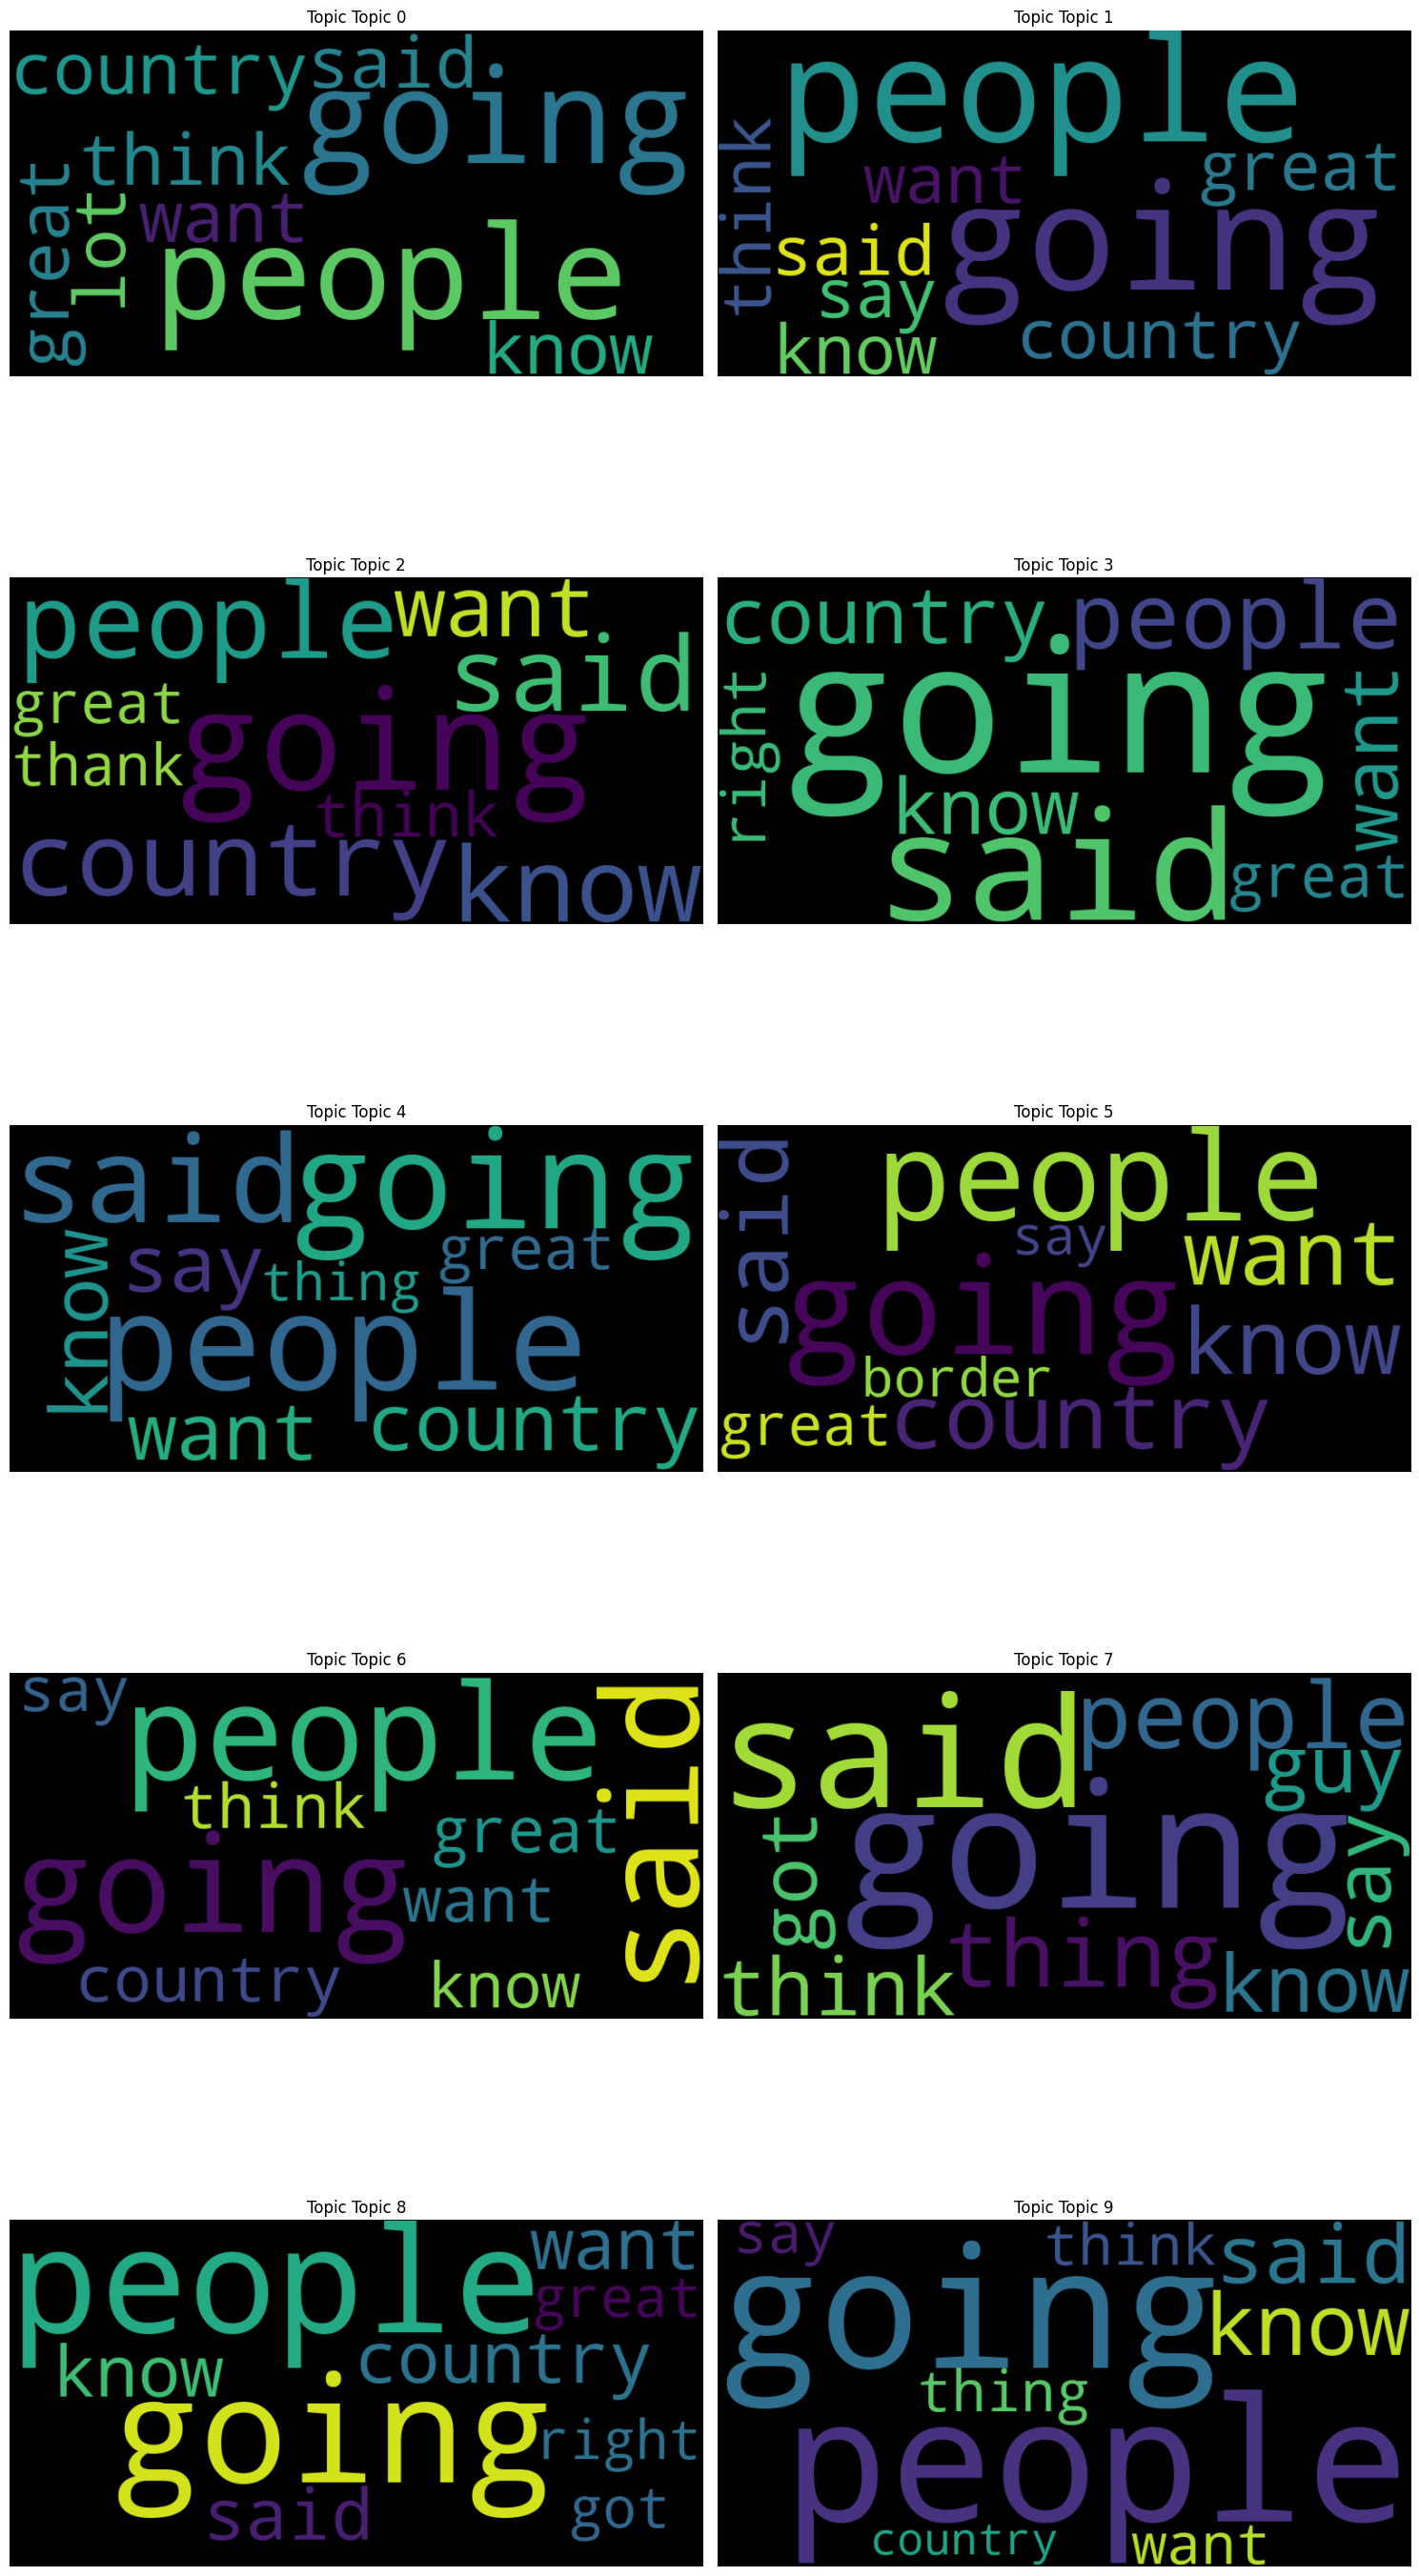

In [27]:
plot_word_clouds_subplots(topic_keywords)

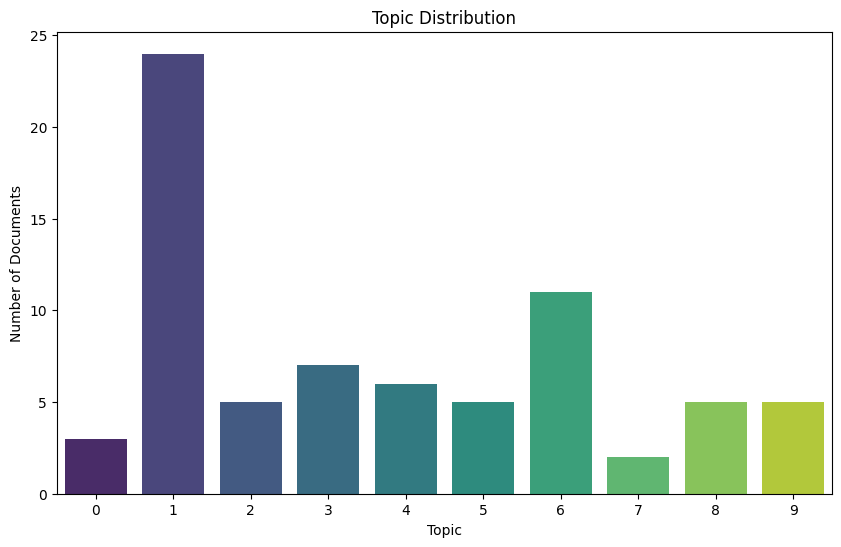

In [28]:
import seaborn as sns

# Plot topic distribution
def plot_topic_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='topic', data=df, palette='viridis')
    plt.title('Topic Distribution')
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.show()

plot_topic_distribution(df)

# Network Graphs

In [29]:
df1 = df.copy() 
df1['len'] = df['speech'].apply(lambda x: len(x))
df1 = df1.sort_values(by = ['len']).reset_index(drop = True)

In [30]:
# preprocess Text
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return filtered_words

# extract Relationships (Co-occurrence of Words)
def extract_relationships(speeches):
    relationships = []
    for speech in speeches:
        words = preprocess_text(speech)
        relationships.extend(combinations(set(words), 2))  # Create word pairs
    return relationships

relationships = extract_relationships(df1.loc[[0, 72], 'speech'])

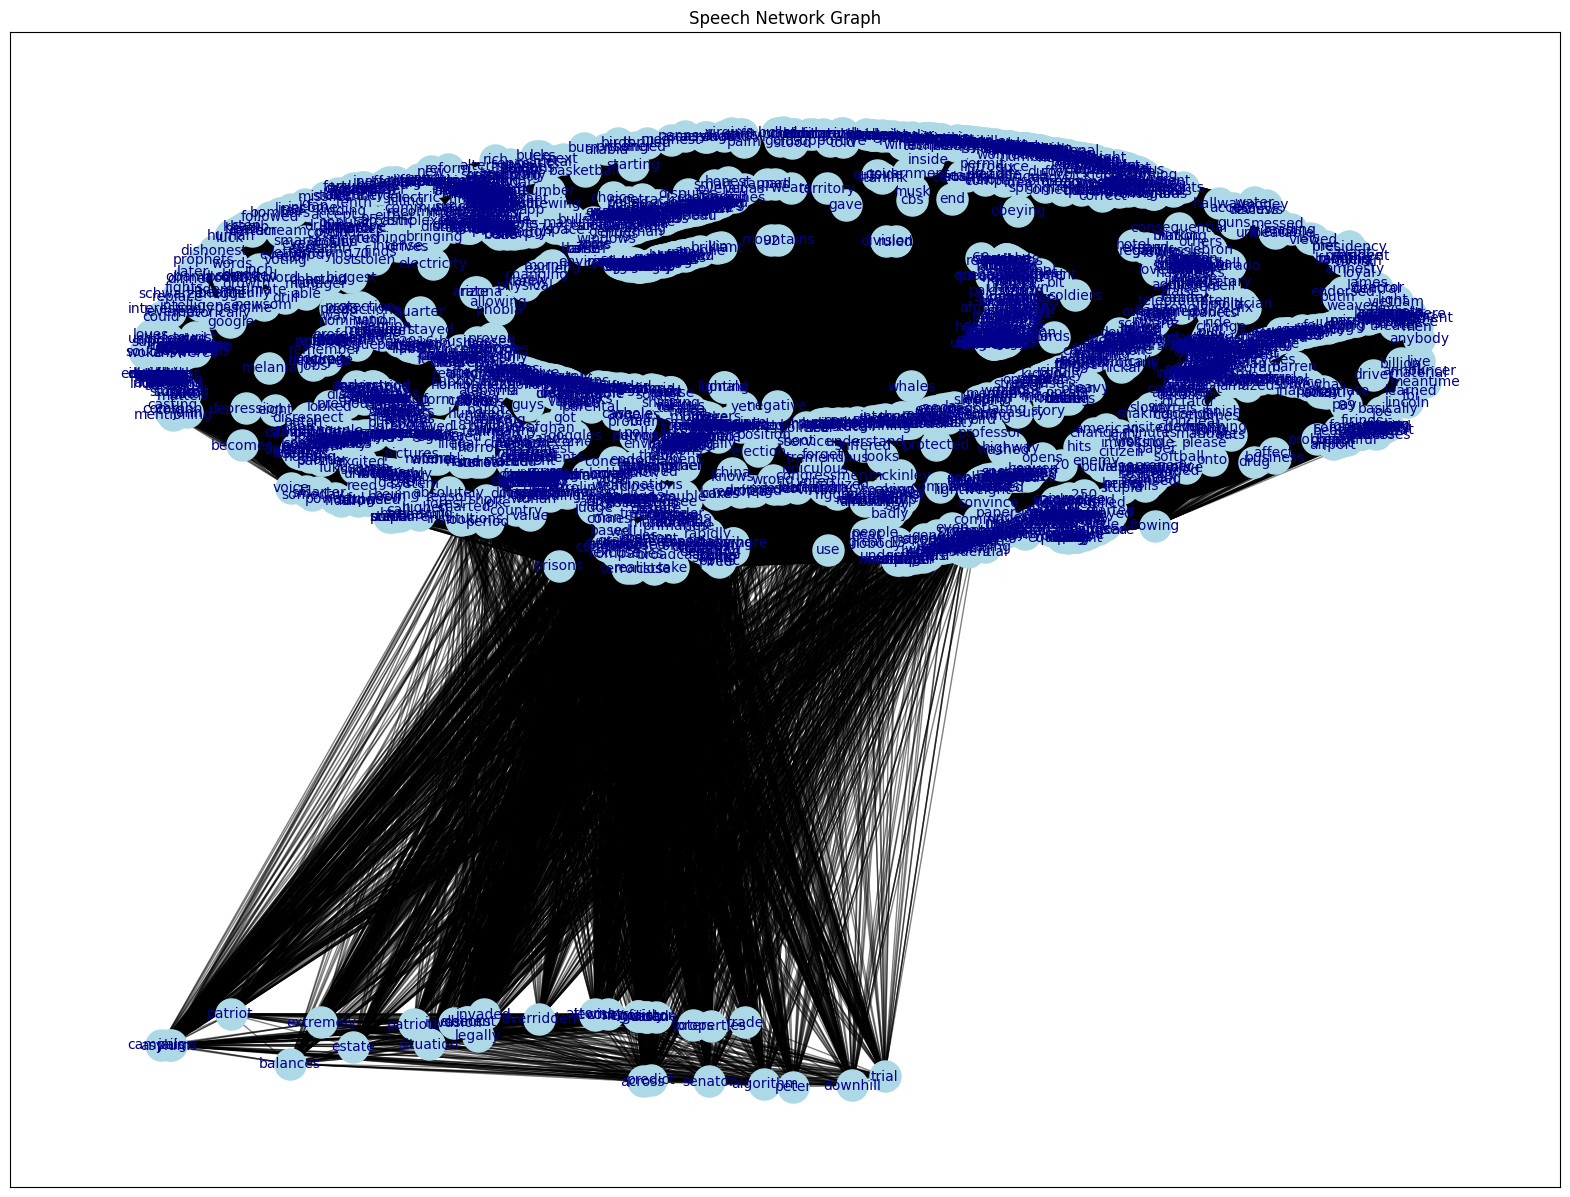

In [31]:
# build the Network Graph
G = nx.Graph()
G.add_edges_from(relationships)

# visualize the Graph
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, seed=42)  # Set a layout for better visualization
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="darkblue")
plt.title("Speech Network Graph")
plt.show()

In [43]:
df1.sort_values(by = 'date').tail(10)

date                    location     deliverer      title  \
8  2024-10-21             Memorial Dinner  Donald Trump    Unknown   
20 2024-10-21            Detroit Michigan  Donald Trump      Rally   
18 2024-10-22              North Carolina  Donald Trump    Unknown   
2  2024-10-22       Auburn Hills Michigan  Donald Trump    Unknown   
17 2024-10-23               Miami Florida  Donald Trump    Unknown   
42 2024-10-24   Greensboro North Carolina  Donald Trump      Rally   
36 2024-10-28       Madison Square Garden  Donald Trump      Rally   
33 2024-10-28               Novi Michigan  Donald Trump      Rally   
40 2024-10-28  State College Pennsylvania  Donald Trump      Rally   
72 2024-10-28                     Unknown  Donald Trump  Interview   

                                               speech  \
8   \nThank you, everybody. Well, thank you very m...   
20  \nThank you everybody. Thank you. Thank you ve...   
18  \nThank you very much. You know, over the year...   
2   \nYeah. And I want to thank Brian and all the ...   
17  \nWow, got so quiet.\n\n\nWell, thank you very...   
42  \nThank you.(26:51)Remember when I said no tax...   
36  \nThis is the final battle. With you at my sid...   
33  \nWhen I’m re-elected, I will totally oblitera...   
40  \nWow.\n\n\nWell, thank you very much. This is...   
72  \nLet’s go.\n\n\nSure.\n\n\nThat’s right.\n\n\...   

                                       cleaned_speech  \
8   thank everybody well thank much honor told cir...   
20  thank everybody thank thank much special love ...   
18  thank much know year heard song sung others ho...   
2   yeah want thank brian people uaw autoworkers f...   
17  wow got quiet well thank much everybody great ...   
42  thank 26 51 remember said tax tip like month l...   
36  final battle side demolish deep state expel wa...   
33  elected totally obliterate deep state long pri...   
40  wow well thank much quite gathering getting en...   
72  let u go sure right yeah last week one last sh...   

                                               tokens  \
8   [thank, everybody, well, thank, much, honor, t...   
20  [thank, everybody, thank, thank, much, special...   
18  [thank, much, know, year, heard, song, sung, o...   
2   [yeah, want, thank, brian, people, uaw, autowo...   
17  [wow, got, quiet, well, thank, much, everybody...   
42  [thank, 26, 51, remember, said, tax, tip, like...   
36  [final, battle, side, demolish, deep, state, e...   
33  [elected, totally, obliterate, deep, state, lo...   
40  [wow, well, thank, much, quite, gathering, get...   
72  [let, u, go, sure, right, yeah, last, week, on...   

                                  tokens_no_stopwords  \
8   [thank, everybody, well, thank, much, honor, t...   
20  [thank, everybody, thank, thank, much, special...   
18  [thank, much, know, year, heard, song, sung, o...   
2   [yeah, want, thank, brian, people, uaw, autowo...   
17  [wow, got, quiet, well, thank, much, everybody...   
42  [thank, 26, 51, remember, said, tax, tip, like...   
36  [final, battle, side, demolish, deep, state, e...   
33  [elected, totally, obliterate, deep, state, lo...   
40  [wow, well, thank, much, quite, gathering, get...   
72  [let, u, go, sure, right, yeah, last, week, on...   

                                    lemmatized_tokens  \
8   [thank, everybody, well, thank, much, honor, t...   
20  [thank, everybody, thank, thank, much, special...   
18  [thank, much, know, year, heard, song, sung, o...   
2   [yeah, want, thank, brian, people, uaw, autowo...   
17  [wow, got, quiet, well, thank, much, everybody...   
42  [thank, 26, 51, remember, said, tax, tip, like...   
36  [final, battle, side, demolish, deep, state, e...   
33  [elected, totally, obliterate, deep, state, lo...   
40  [wow, well, thank, much, quite, gathering, get...   
72  [let, u, go, sure, right, yeah, last, week, on...   

                                     processed_speech sentiment  topic  \
8   thank everybody well

In [32]:
def preprocess_text(text):
    words = text.split()
    return [word for word in words if len(word) > 1 and re.match(r'^[a-zA-Z0-9]+$', word)]

df1['processed_speech_1'] = df1['processed_speech'].apply(preprocess_text)

relationships_1 = []
for words in df1['processed_speech_1'].loc[0:1]:
    relationships_1.extend(combinations(set(words), 2))  # Pair unique words in each speech

G = nx.Graph()
G.add_edges_from(relationships_1)

word_locations = {}
for index, row in df1.loc[0:1].iterrows():
    for word in row['processed_speech_1']:
        word_locations[word] = word_locations.get(word, 0) + 1

nx.set_node_attributes(G, word_locations, 'frequency')
nx.set_node_attributes(G, {node: node for node in G.nodes()}, 'label')  # Set labels explicitly

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

# ipysigma for visualization
sigma_graph = Sigma(
    G,
    node_color="frequency",  
    node_size="degree",  
    node_label="label",  
    node_label_size="degree", 
    default_node_label=False  
)


sigma_graph


Sigma(nx.Graph with 324 nodes and 35,312 edges)

In [50]:

relationships_1 = []
for words in df1['processed_speech_1'].iloc[[0, 33]]:
    relationships_1.extend(combinations(set(words), 2))  # Pair unique words in each speech

G = nx.Graph()
G.add_edges_from(relationships_1)

word_locations = {}
for index, row in df1.iloc[[0, 33]].iterrows():
    for word in row['processed_speech_1']:
        word_locations[word] = word_locations.get(word, 0) + 1

nx.set_node_attributes(G, word_locations, 'frequency')
nx.set_node_attributes(G, {node: node for node in G.nodes()}, 'label')  # Set labels explicitly

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

# ipysigma for visualization
sigma_graph = Sigma(
    G,
    node_color="frequency",  
    node_size="degree",  
    node_label="label",  
    node_label_size="degree", 
    default_node_label=False  
)


sigma_graph

Sigma(nx.Graph with 1,372 nodes and 893,804 edges)

In [52]:
Sigma.write_html(
    G,
    'speech_network.html',
    fullscreen=True,
    node_metrics=['louvain'],
    node_color='degree',
    node_size='degree',
    default_node_label=True
)